In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from fastai.vision import *
from fastai.metrics import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
path = '../input'
print(os.listdir(path))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test.csv', 'train.csv']


## Load data

In [2]:
class CustomImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
        img = np.stack((img,)*3, axis=-1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        
        return res

In [3]:
test = CustomImageList.from_csv_custom(path=path, csv_name='test.csv', imgIdx=0)

In [4]:
tfms = get_transforms(do_flip=False)
data = (CustomImageList.from_csv_custom(path=path, csv_name='train.csv', imgIdx=1)
                .split_by_rand_pct(.2)
                .label_from_df(cols='label')
                .add_test(test, label=0)
                .transform(tfms)
                .databunch(bs=128, num_workers=0)
                .normalize(imagenet_stats))

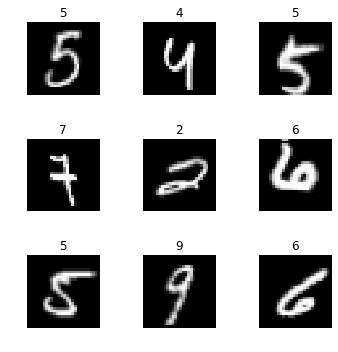

In [5]:
data.show_batch(rows=3, figsize=(5,5))

## Train Model

In [6]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir='/kaggle/working/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.torch/models/resnet50-19c8e357.pth
102502400it [00:02, 49871012.17it/s]


In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


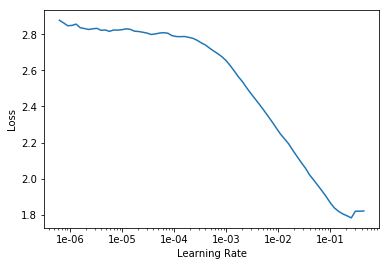

In [8]:
learn.recorder.plot()

In [9]:
lr = 1e-2
learn.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.367268,0.164156,0.946667,00:49
1,0.134138,0.093044,0.971667,00:49
2,0.131168,0.121883,0.965714,00:47
3,0.103557,0.070249,0.978929,00:48
4,0.088997,0.040658,0.987857,00:48
5,0.071032,0.047760,0.985833,00:47
6,0.050103,0.039999,0.986548,00:52
7,0.039321,0.023819,0.992024,00:47
8,0.030135,0.018940,0.993095,00:48
9,0.024938,0.017825,0.993929,00:48


In [10]:
learn.save('stage1-resnet50')

In [11]:
learn.load('stage1-resnet50')
learn.validate()

[0.017824875, tensor(0.9939)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


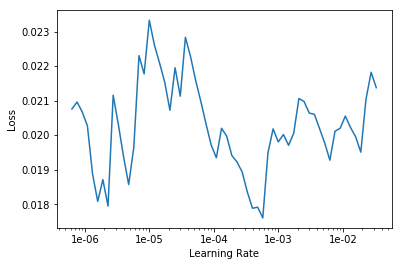

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6, 2.5e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.027221,0.019607,0.993452,00:52
1,0.022615,0.017753,0.993333,00:51
2,0.026423,0.018865,0.993810,00:54
3,0.018844,0.018284,0.994286,00:51
4,0.018721,0.018316,0.994048,00:51


In [14]:
learn.validate()

[0.018316034, tensor(0.9940)]

## Submit

In [15]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)